# The spark version is 2.4.3 but if the link fails go to and see which is the spark version available


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
file_path = "drive/My Drive/BIG DATA PROJECT/clean_data/"

In [0]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize']=(20,10)

In [0]:
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

df_accidents = sc.read.csv(file_path+'2010/accidents.csv', header=True)
for year in years:
  new_df = sc.read.csv(file_path+year+'/accidents.csv', header=True)
  df_accidents = df_accidents.union(new_df)
  
df_people = sc.read.csv(file_path+'2010/persones.csv', header=True)
for year in years:
  new_df = sc.read.csv(file_path+year+'/persones.csv', header=True)
  df_people = df_people.union(new_df)
df_people.show()

+------------------+------------------------+----------------------------+---------------+------------------------+----+------------------------+
|Número d'expedient|Descripció causa vianant|Desc. Tipus vehicle implicat|Descripció sexe|Descripció tipus persona|Edat|Descripció victimització|
+------------------+------------------------+----------------------------+---------------+------------------------+----+------------------------+
|   2010S000001    |    No és causa del  ...|                 Motocicleta|           Home|               Conductor|  30|              Ferit lleu|
|   2010S000001    |    No és causa del  ...|                 Motocicleta|           Home|               Conductor|  39|              Ferit lleu|
|   2010S000002    |    No és causa del  ...|                  Ciclomotor|           Home|               Conductor|  39|              Ferit lleu|
|   2010S000005    |    No és causa del  ...|                 Motocicleta|           Home|               Conductor|  34|    

# In this section, people involved in accidents in BCN will be analyzed

## First, the study will show the ages of people involved in accidents.

In [0]:
from functools import reduce
from pyspark.sql import functions as F

sc.conf.set("spark.sql.crossJoin.enabled", "true")
df_va = df_accidents.select('Número d\'expedient').dropDuplicates().join(df_people, ["Número d'expedient"])
ages = df_va


oldColumns = ages.schema.names
newColumns = ["numero_expedient", "causa", "vehicle_implicat", "sexe", "tipus_person","edat", "victimitzacio"]

ages = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), ages)
ages = ages.filter(ages.edat!="Conductor")
ages = ages.filter(ages.edat!="Passatger")
ages = ages.filter(ages.edat!="Vianant")
ages = ages.filter(ages.edat!="Desconegut")
ages = ages.withColumn("range", F.when(ages["edat"].between(0,11), "child").when(ages["edat"].between(12,18), "teenager").when(ages["edat"].between(19,35), "young adult").when(ages["edat"].between(36,65), "adult").otherwise("advanced age"))



In [0]:
ages_count = ages.groupby('range').count().orderBy("count", ascending=False)

oldColumns = ages_count.schema.names
newColumns = ["range", "number"]

ages_count = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), ages_count)

ages_count.show()

+------------+------+
|       range|number|
+------------+------+
|       adult| 15262|
| young adult| 15211|
|advanced age|  2293|
|    teenager|  1191|
|       child|   875|
+------------+------+



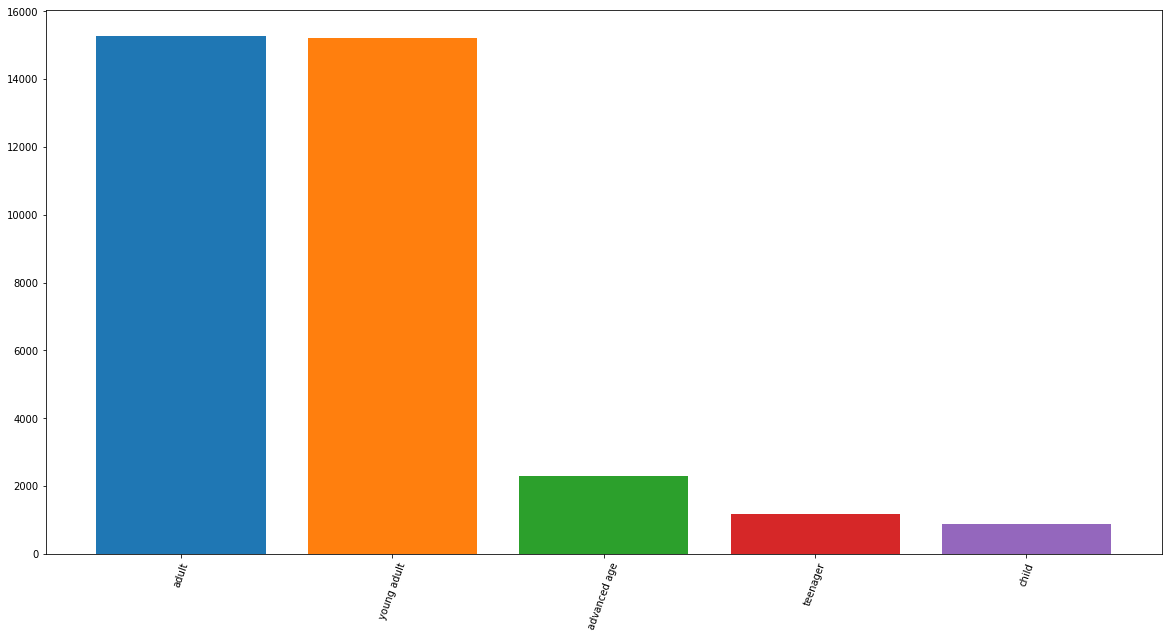

In [0]:
for age in ages_count.collect()[:30]:
  plt.bar(age.range, age.number)
  plt.xticks(rotation=70)
plt.show()

*   Children: from 0 to 11
*   Teenager: from 12 to 18
*   Young adult: from 19 to 35
*   Adult: from 36 to 65
*   Advanced age: from 65 to infinite

We can see that normally the people involved in traffic accidents are adults, is normal because normally people in vehicles are from those ages. Even the number of teenagers and children involved in accidents is less, this quantity is critical.

## Let's check which genre is more involved in traffic accidents.

In [0]:
sex_count = ages.groupby('sexe').count().orderBy("count", ascending=False)

oldColumns = sex_count.schema.names
newColumns = ["sexe", "number"]

sex_count = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), sex_count)
sex_count = sex_count.filter(sex_count.sexe!="Desconegut")

sex_count.show()

+----+------+
|sexe|number|
+----+------+
|Home| 21401|
|Dona| 13427|
+----+------+



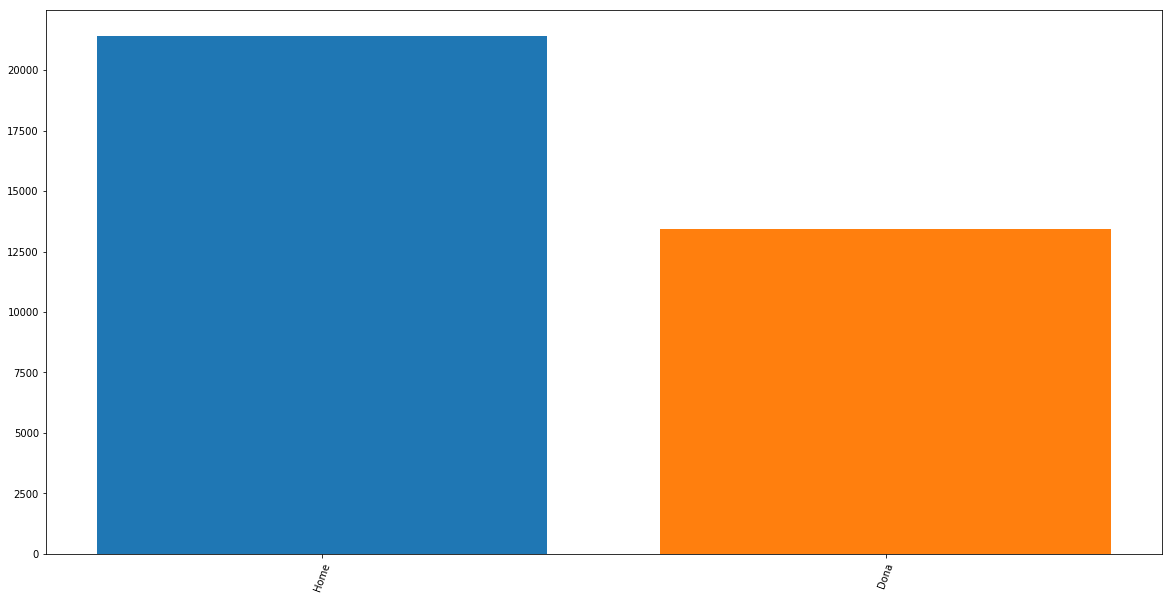

In [0]:
for sex in sex_count.collect()[:30]:
  plt.bar(sex.sexe, sex.number)
  plt.xticks(rotation=70)
plt.show()

As it's shown in the previous image, the number of men involved in accidents is almost double as women. It could happen because probably men are less careful driving and walking around the city.